In [677]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

# NEW CLASS AND ACTIVATION FUNCTIONS RUN THIS

In [678]:
def softmax(z):
    e = np.exp(z)
    return e / np.sum(e, axis=0,keepdims=True)

In [679]:
def softmax_grad(s):
    s=softmax(s.T)
    return (s*(1-s)).T   

In [680]:
def ReLU(x):
    return x * (x > 0)

In [681]:
def ReLU_grad(x):
    return 1. * (x > 0)

In [682]:
def tanh(z):
    e = np.exp(2*z)
    return 1-2/(e+1)

In [683]:
def tanh_grad(z):
    return 1-tanh(z)**2

In [684]:
def MSE(Y,Y_hat):
    return np.sum((Y-Y_hat)**2)

In [685]:
def MSE_grad(Y,Y_hat):
     return Y_hat-Y

In [686]:
def sigmoid(x):
    return(1/(1 + np.exp(-x)))

In [687]:
def sigmoid_grad(x):
    return(sigmoid(x)*(1-sigmoid(x)))

In [688]:
def cross_entropy(targets,predictions,  epsilon=1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    ce = abs(np.sum(targets*np.log(predictions)))
    return ce


In [689]:
def cross_entropy_grad(Y,Y_hat,eps=10**-10):
    Y_hat=Y_hat+eps
    return (Y_hat-eps-Y)/Y_hat/(1-Y_hat)

In [690]:
def identity(x):
    return x

In [691]:
def identity_grad(x):
    return 1

In [692]:
class MLP_new:
    def __init__(self, input_layer_len, output_layer_len, hidden_layers_len,
                 activation_functions,activation_functions_grad,cost_function,cost_function_grad,seed=123):
        
        np.random.seed(seed)
        
        self.activation_functions=activation_functions
        self.activation_functions_grad=activation_functions_grad
        
        self.cost_function=cost_function
        self.cost_function_grad=cost_function_grad
        
        self.input_layer = np.zeros((1,input_layer_len))
        self.output_layer = np.zeros((1,output_layer_len))
        self.output_before =np.zeros((1,output_layer_len))
        self.weights=[]
        
        self.weights.append(np.random.random((hidden_layers_len[0],input_layer_len))*2-1)
        
        for i in range(1,len(hidden_layers_len)):
            self.weights.append(np.random.random((hidden_layers_len[i],hidden_layers_len[i-1]))*2-1)
            
        self.weights.append(np.random.random((output_layer_len,hidden_layers_len[-1]))*2-1)
        
        self.biases=[]
        
        for i in range(len(hidden_layers_len)):
            self.biases.append(np.zeros((hidden_layers_len[i],1)))
            
        
        self.biases.append(np.zeros((output_layer_len,1)))
        
        self.hidden_layers=[]
        
        for i in range(len(hidden_layers_len)):
            self.hidden_layers.append(np.zeros((hidden_layers_len[i],1)))
        
    
        
    def calculate(self,input_layer,memory=False):
        self.input_layer=input_layer
        
        input_layer=input_layer.T
        
        if(memory):
            for i in range(len(self.weights)-1):
                
                self.hidden_layers[i]=self.weights[i].dot(input_layer)+self.biases[i]
                input_layer=self.activation_functions[i](self.hidden_layers[i])
                
        else:    
            for i in range(len(self.weights)-1):
                input_layer=self.activation_functions[i](self.weights[i].dot(input_layer)+self.biases[i])
                
        
       
        output_layer=self.activation_functions[-1](self.weights[-1].dot(input_layer)+self.biases[-1])
        self.output_before=(self.weights[-1].dot(input_layer)+self.biases[-1]).T
        self.output_layer=output_layer.T
        
        return(output_layer.T)
        
    def train(self,train_input_layer,train_output_layer,max_epoch=2000,rate=0.05,beta=0.8,batch=0.2,stop=10**-6,RMSprop=False,eps=10**-8,return_error_list=True):
        #creating batches
        lin=np.linspace(0,train_input_layer.shape[0],int(1/batch)+1).round().astype(int)
        output_layer=self.calculate(train_input_layer)
        error=self.cost_function(train_output_layer,output_layer)
        print("start error "+str(error))
        old_gradient=[[0]*(len(lin)-1) for x in range(len(self.weights))]
        old_gradient_bias=[[0]*(len(lin)-1) for x in range(len(self.weights))]
        error_list=[error]
        
        
        for epoch in range(1,max_epoch+1):
            
            for b in range(len(lin)-1):

                input_layer=train_input_layer[lin[b]:lin[b+1]]
                output_layer=self.calculate(input_layer,memory=True)
                
                batch_size=output_layer.shape[0]
                errors=[[0]*len(self.weights) for x in range(batch_size)]

                for x in range(batch_size):
                    #all cost functions should be independent from size of vectors because we rescale them later
                    #last activation function is used at output_layer so for classification it should be softmax and for regresion identity
                    errors[x][-1]=((self.cost_function_grad(train_output_layer[lin[b]:lin[b+1]][x:x+1],output_layer[x:x+1]))*self.activation_functions_grad[-1](self.output_before[x:x+1])).T
                    for i in range(len(self.weights)-2,-1,-1): 
                        errors[x][i]=self.weights[i+1].T.dot(errors[x][i+1])*self.activation_functions_grad[i](self.hidden_layers[i][:,x:x+1])
                
                
                
                for l in range(1,len(self.weights)):
                    #we rescale by batch size here
                    #new_gradient=np.clip(new_gradient,-10**6,10**6) is used to prevent weights exploding
                    #we update gradients beta here is momentum
                    if(RMSprop):
                        new_gradient=sum([errors[x][l].dot(self.activation_functions[l-1](self.hidden_layers[l-1][x:x+1]).T) for x in range(batch_size)])/batch_size
                        new_gradient=np.clip(new_gradient,-10**6,10**6)
                        old_gradient[l][b]=beta*old_gradient[l][b]+(1-beta)*new_gradient**2
                        self.weights[l]=self.weights[l]-new_gradient*(rate/(np.sqrt(old_gradient[l][b])+eps))

                        new_gradient_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                        new_gradient=np.clip(new_gradient,-10**6,10**6)
                        old_gradient_bias[l][b]=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias**2
                        self.biases[l]=self.biases[l]-new_gradient_bias*(rate/(np.sqrt(old_gradient_bias[l][b])+eps))
                    else:
                        
                        new_gradient=sum([errors[x][l].dot(self.activation_functions[l-1](self.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                        new_gradient=np.clip(new_gradient,-10**6,10**6)
                        new_gradient=beta*old_gradient[l][b]+(1-beta)*new_gradient
                        old_gradient[l][b]=new_gradient
                        self.weights[l]=self.weights[l]-new_gradient*rate

                        new_gradient_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                        new_gradient_bias=np.clip(new_gradient_bias,-10**6,10**6)
                        new_gradient_bias=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias
                        old_gradient_bias[l][b]=new_gradient_bias
                        self.biases[l]=self.biases[l]-new_gradient_bias*rate

                if(RMSprop):
                    new_gradient=sum([errors[x][0].dot((self.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
                    new_gradient=np.clip(new_gradient,-10**6,10**6)
                    old_gradient[0][b]=beta*old_gradient[0][b]+(1-beta)*new_gradient**2
                    self.weights[0]=self.weights[0]-new_gradient*(rate/(np.sqrt(old_gradient[0][b])+eps))

                    new_gradient_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
                    new_gradient_bias=np.clip(new_gradient_bias,-10**6,10**6)
                    old_gradient_bias[0][b]=beta*old_gradient_bias[0][b]+(1-beta)*new_gradient_bias**2
                    self.biases[0]=self.biases[0]-new_gradient_bias*(rate/(np.sqrt(old_gradient_bias[0][b])+eps))
                else:
                    new_gradient=sum([errors[x][0].dot((self.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
                    new_gradient=np.clip(new_gradient,-10**6,10**6)
                    new_gradient=beta*old_gradient[0][b]+(1-beta)*new_gradient
                    old_gradient[0][b]=new_gradient
                    self.weights[0]=self.weights[0]-new_gradient*rate

                    new_gradient_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
                    new_gradient_bias=np.clip(new_gradient_bias,-10**6,10**6)
                    new_gradient_bias=beta*old_gradient_bias[0][b]+(1-beta)*new_gradient_bias
                    old_gradient_bias[0][b]=new_gradient_bias
                    self.biases[0]=self.biases[0]-new_gradient_bias*rate


            output_layer=self.calculate(train_input_layer)
            new_error=self.cost_function(train_output_layer,output_layer)
            if return_error_list:
                error_list.append(new_error)
            
            if(epoch % 500 == 0):
                print("epoch "+str(epoch))
                
            if new_error<=0:
                break
            
            if ((abs(new_error-error)/error)<stop).all():
                break

            error=new_error
        
        print("end epoch in "+str(epoch)+ " with error "+str(new_error))
        if return_error_list:
            return error_list
        else:
            return new_error
        
        

# test of diffrent activation functions RUN THIS

In [693]:
df=pd.DataFrame(columns=["problem","dataset","layers","activation_function","accuracy_train","accuracy_test"])

In [694]:
networks=[]

In [695]:
networks_names=[]

In [696]:
networks_err=[]

In [697]:
np.random.seed(123)

# increase this for better results but longer computations

In [698]:
MAX_EPOCH=250

# rings5

In [699]:
test = np.loadtxt("mio1/classification/rings5-regular-training.csv", delimiter=',', skiprows=1, usecols=range(0,3))
np.random.shuffle(test)
X=test[:,0:2]
Y=test[:,2:3]
#one-hot-encode
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [700]:
test = np.loadtxt("mio1/classification/rings5-regular-test.csv", delimiter=',', skiprows=1, usecols=range(0,3))
X=test[:,0:2]
Y=test[:,2:3]
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y

In [701]:
for l in [[7,6,5],[7,6],[7]]:
    mlp_start=MLP_new(2,5,l,[identity]*len(l)+[softmax],[identity_grad]*len(l)+[softmax_grad],cross_entropy,cross_entropy_grad)
    for f in ["sigmoid","ReLU","identity","tanh"]:
        #inicjujemy siec neuronowa z odpowiednimi funkcjami aktywacji, ich pochodnymi, oraz funkcja kosztu i jej pochodna
        if f=="sigmoid":
             mlp_test=MLP_new(2,5,l,[sigmoid]*len(l)+[softmax],[sigmoid_grad]*len(l)+[softmax_grad],cross_entropy,cross_entropy_grad)
        
        if f=="ReLU":
             mlp_test=MLP_new(2,5,l,[ReLU]*len(l)+[softmax],[ReLU_grad]*len(l)+[softmax_grad],cross_entropy,cross_entropy_grad)
        
        if f=="identity":
             mlp_test=MLP_new(2,5,l,[identity]*len(l)+[softmax],[identity_grad]*len(l)+[softmax_grad],cross_entropy,cross_entropy_grad)
        
        if f=="tanh":
             mlp_test=MLP_new(2,5,l,[tanh]*len(l)+[softmax],[tanh_grad]*len(l)+[softmax_grad],cross_entropy,cross_entropy_grad)
        
        #wszystkie zaczynaja od tych samych wag
        mlp_test.weights=mlp_start.weights.copy()
        mlp_test.biases=mlp_start.biases.copy()
        er=mlp_test.train(train_input_layer,train_output_layer,batch=0.2,rate=0.05,beta=0.9,max_epoch=MAX_EPOCH)
        #zapisujemy
        networks.append(deepcopy(mlp_test))
        networks_err.append(er.copy())
        networks_names.append("ring5-"+f+"-"+str(len(l)))
        output_layer=mlp_test.calculate(train_input_layer)
        ac_train=np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1))
        output_layer=mlp_test.calculate(test_input_layer)
        ac_test=np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1))
        df=df.append({"problem":"classification","dataset":"rings5-regular","layers":len(l),"activation_function":f,"accuracy_train":ac_train,"accuracy_test":ac_test},ignore_index=True)


start error 2427.2308971615003
end epoch in 250 with error 1992.9027503238829
start error 2234.9831091410892
end epoch in 250 with error 883.5312196133739
start error 2900.816305834476
end epoch in 65 with error 1710.7440290071331
start error 2038.5274150140845
end epoch in 250 with error 1440.7979202026013
start error 2205.9960656899193
end epoch in 250 with error 1929.2362870909433
start error 2152.997457841503
end epoch in 250 with error 1330.336593812889
start error 3573.5669662343976
end epoch in 121 with error 1710.6872893977263
start error 2686.618432299965
end epoch in 250 with error 1288.116528522984
start error 2109.5901999931675
end epoch in 250 with error 1699.4835062347395
start error 2105.324830770878
end epoch in 250 with error 1222.1272502875893
start error 2358.720101955293
end epoch in 98 with error 1710.6773007601437
start error 2193.169380832136
end epoch in 250 with error 1446.8400511927102


accuracy train
0.4496
accuracy test
0.456


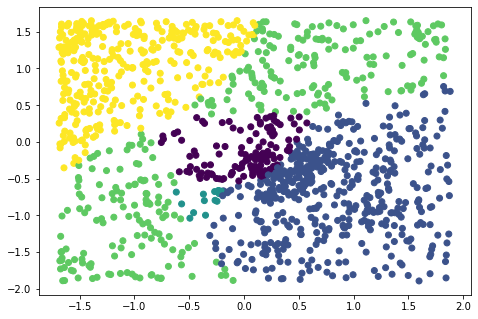

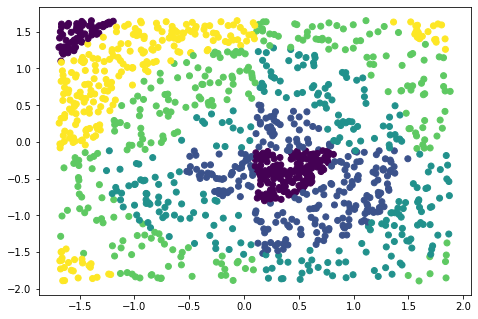

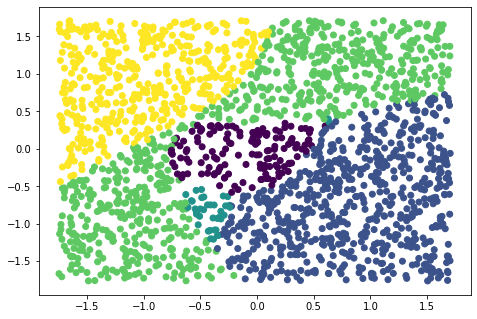

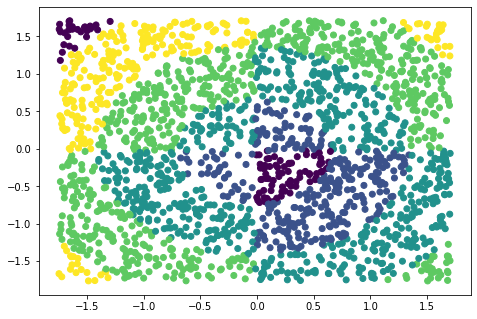

In [702]:
output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(output_layer,axis=1))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
print("accuracy train")
print(np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1)))

output_layer=mlp_test.calculate(test_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(output_layer,axis=1))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(test_output_layer,axis=1))
print("accuracy test")
print(np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1)))

# rings3

In [703]:
test = np.loadtxt("mio1/classification/rings3-regular-training.csv", delimiter=',', skiprows=1, usecols=range(0,3))
np.random.shuffle(test)
X=test[:,0:2]
Y=test[:,2:3]
#one-hot-encode
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [704]:
test = np.loadtxt("mio1/classification/rings3-regular-test.csv", delimiter=',', skiprows=1, usecols=range(0,3))
X=test[:,0:2]
Y=test[:,2:3]
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y

In [705]:
for l in [[7,6,5],[7,6],[7]]:
    mlp_start=MLP_new(2,3,l,[identity]*len(l)+[softmax],[identity_grad]*len(l)+[softmax_grad],cross_entropy,cross_entropy_grad)
    for f in ["sigmoid","ReLU","identity","tanh"]:
        #inicjujemy siec neuronowa z odpowiednimi funkcjami aktywacji, ich pochodnymi, oraz funkcja kosztu i jej pochodna
        if f=="sigmoid":
             mlp_test=MLP_new(2,3,l,[sigmoid]*len(l)+[softmax],[sigmoid_grad]*len(l)+[softmax_grad],cross_entropy,cross_entropy_grad)
        
        if f=="ReLU":
             mlp_test=MLP_new(2,3,l,[ReLU]*len(l)+[softmax],[ReLU_grad]*len(l)+[softmax_grad],cross_entropy,cross_entropy_grad)
        
        if f=="identity":
             mlp_test=MLP_new(2,3,l,[identity]*len(l)+[softmax],[identity_grad]*len(l)+[softmax_grad],cross_entropy,cross_entropy_grad)
        
        if f=="tanh":
             mlp_test=MLP_new(2,3,l,[tanh]*len(l)+[softmax],[tanh_grad]*len(l)+[softmax_grad],cross_entropy,cross_entropy_grad)
        
        #wszystkie zaczynaja od tych samych wag
        mlp_test.weights=mlp_start.weights.copy()
        mlp_test.biases=mlp_start.biases.copy()
        er=mlp_test.train(train_input_layer,train_output_layer,batch=0.2,rate=0.05,beta=0.9,max_epoch=MAX_EPOCH)
        #zapisujemy
        networks.append(deepcopy(mlp_test))
        networks_err.append(er.copy())
        networks_names.append("ring3-"+f+"-"+str(len(l)))
        output_layer=mlp_test.calculate(train_input_layer)
        ac_train=np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1))
        output_layer=mlp_test.calculate(test_input_layer)
        ac_test=np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1))
        df=df.append({"problem":"classification","dataset":"rings3-regular","layers":len(l),"activation_function":f,"accuracy_train":ac_train,"accuracy_test":ac_test},ignore_index=True)


start error 2316.486817825141
end epoch in 250 with error 1595.5147514236533
start error 1765.7379117047194
end epoch in 250 with error 916.1149293945823
start error 2473.1328247016213
end epoch in 60 with error 1482.3677723327241
start error 1613.3918591408199
end epoch in 250 with error 792.8782717756021
start error 1752.6035134088806
end epoch in 250 with error 1601.4726933814147
start error 2088.2014862042743
end epoch in 250 with error 1272.5228828273255
start error 4769.934174659285
end epoch in 75 with error 1482.0762352036097
start error 3037.1540245732167
end epoch in 250 with error 1112.7462024961478
start error 1691.4401859667296
end epoch in 250 with error 1480.6714172974473
start error 1600.4688827374046
end epoch in 250 with error 1276.123149003683
start error 1611.0553466432284
end epoch in 59 with error 1482.0376895316617
start error 1553.7914391593818
end epoch in 250 with error 1423.3216620404264


accuracy train
0.46066666666666667
accuracy test
0.4865


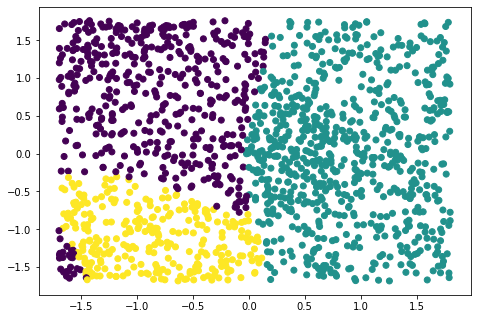

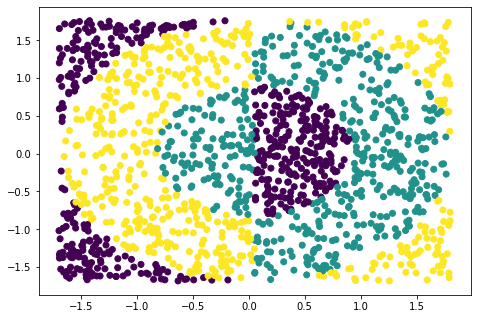

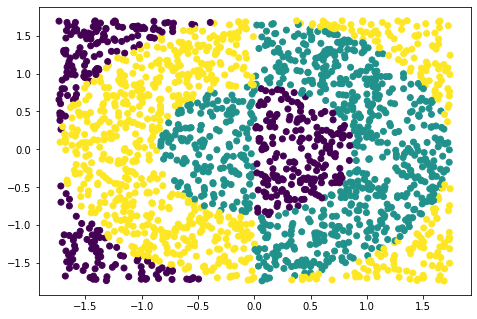

In [706]:
output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(output_layer,axis=1))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
print("accuracy train")
print(np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1)))

output_layer=mlp_test.calculate(test_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(output_layer,axis=1))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(test_output_layer,axis=1))
print("accuracy test")
print(np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1)))

# steps-large

In [707]:
test = np.loadtxt("mio1/regression/steps-large-training.csv", delimiter=',', skiprows=1, usecols=range(1,3))
np.random.shuffle(test)
X=test[:,0:1]
Y=test[:,1:2]
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [708]:
test = np.loadtxt("mio1/regression/steps-large-test.csv", delimiter=',', skiprows=1, usecols=range(1,3))
X=test[:,0:1]
Y=test[:,1:2]
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y

In [709]:
for l in [[7,6,5],[7,6],[7]]:
    mlp_start=MLP_new(1,1,l,[identity]*len(l)+[identity],[identity_grad]*len(l)+[identity_grad],MSE,MSE_grad)
    for f in ["sigmoid","ReLU","identity","tanh"]:
        #inicjujemy siec neuronowa z odpowiednimi funkcjami aktywacji, ich pochodnymi, oraz funkcja kosztu i jej pochodna
        if f=="sigmoid":
             mlp_test=MLP_new(1,1,l,[sigmoid]*len(l)+[identity],[sigmoid_grad]*len(l)+[identity_grad],MSE,MSE_grad)
        
        if f=="ReLU":
             mlp_test=MLP_new(1,1,l,[ReLU]*len(l)+[identity],[ReLU_grad]*len(l)+[identity_grad],MSE,MSE_grad)
        
        if f=="identity":
             mlp_test=MLP_new(1,1,l,[identity]*len(l)+[identity],[identity_grad]*len(l)+[identity_grad],MSE,MSE_grad)
        
        if f=="tanh":
             mlp_test=MLP_new(1,1,l,[tanh]*len(l)+[identity],[tanh_grad]*len(l)+[identity_grad],MSE,MSE_grad)
        
        #wszystkie zaczynaja od tych samych wag
        mlp_test.weights=mlp_start.weights.copy()
        mlp_test.biases=mlp_start.biases.copy()
        er=mlp_test.train(train_input_layer,train_output_layer,batch=0.2,rate=0.05,beta=0.9,max_epoch=MAX_EPOCH)
        #zapisujemy
        networks.append(deepcopy(mlp_test))
        networks_err.append(er.copy())
        networks_names.append("steps-large-"+f+"-"+str(len(l)))
        output_layer=mlp_test.calculate(train_input_layer)
        ac_train=MSE(train_output_layer,output_layer)/output_layer.shape[0]
        output_layer=mlp_test.calculate(test_input_layer)
        ac_test=MSE(test_output_layer,output_layer)/output_layer.shape[0]
        df=df.append({"problem":"regression","dataset":"steps-large","layers":len(l),"activation_function":f,"accuracy_train":ac_train,"accuracy_test":ac_test},ignore_index=True)


start error 73726485.59413272
end epoch in 250 with error 1344003.8685151471
start error 73793862.37431902
end epoch in 149 with error 68293225.3168661
start error 74162630.00840524
end epoch in 250 with error 5.468482974324061e+48
start error 74009616.38020271
end epoch in 250 with error 656787.426268774
start error 73827428.19104879
end epoch in 250 with error 450775.4687374539
start error 73961536.68025212
end epoch in 62 with error 68307714.12642047
start error 74800088.80300795
end epoch in 250 with error 8.712421773382345e+36
start error 74343967.46927814
end epoch in 250 with error 833424.6681584032
start error 74111775.5137302
end epoch in 250 with error 768988.5012833474
start error 74274241.82693754
end epoch in 136 with error 68293220.99583441
start error 74422093.69497028
end epoch in 250 with error 4.742700013532724e+26
start error 74079035.393443
end epoch in 250 with error 327820.47640211455


train MSE
32.78204764021145
test MSE
7148.923546652144


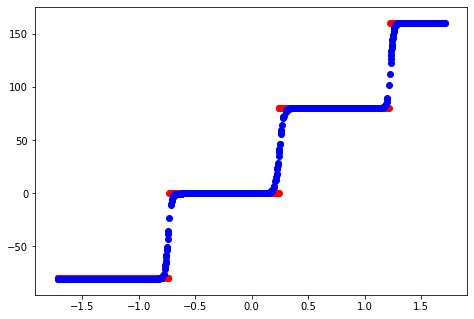

In [710]:
output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer, train_output_layer, color='r')
ax.scatter(train_input_layer,output_layer,color="b")
print("train MSE")
print(MSE(train_output_layer,output_layer)/output_layer.shape[0])

output_layer=mlp_test.calculate(test_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer, test_output_layer, color='r')
ax.scatter(test_input_layer,output_layer,color="b")
print("test MSE")
print(MSE(test_input_layer,output_layer)/output_layer.shape[0])

# multimodal-large

In [711]:
test = np.loadtxt("mio1/regression/multimodal-large-training.csv", delimiter=',', skiprows=1, usecols=range(1,3))
np.random.shuffle(test)
X=test[:,0:1]
Y=test[:,1:2]
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [712]:
test = np.loadtxt("mio1/regression/multimodal-large-test.csv", delimiter=',', skiprows=1, usecols=range(1,3))
X=test[:,0:1]
Y=test[:,1:2]
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y

In [714]:
for l in [[7,6,5],[7,6],[7]]:
    mlp_start=MLP_new(1,1,l,[identity]*len(l)+[identity],[identity_grad]*len(l)+[identity_grad],MSE,MSE_grad)
    for f in ["sigmoid","ReLU","identity","tanh"]:
        #inicjujemy siec neuronowa z odpowiednimi funkcjami aktywacji, ich pochodnymi, oraz funkcja kosztu i jej pochodna
        if f=="sigmoid":
             mlp_test=MLP_new(1,1,l,[sigmoid]*len(l)+[identity],[sigmoid_grad]*len(l)+[identity_grad],MSE,MSE_grad)
        
        if f=="ReLU":
             mlp_test=MLP_new(1,1,l,[ReLU]*len(l)+[identity],[ReLU_grad]*len(l)+[identity_grad],MSE,MSE_grad)
        
        if f=="identity":
             mlp_test=MLP_new(1,1,l,[identity]*len(l)+[identity],[identity_grad]*len(l)+[identity_grad],MSE,MSE_grad)
        
        if f=="tanh":
             mlp_test=MLP_new(1,1,l,[tanh]*len(l)+[identity],[tanh_grad]*len(l)+[identity_grad],MSE,MSE_grad)
        
        #wszystkie zaczynaja od tych samych wag
        mlp_test.weights=mlp_start.weights.copy()
        mlp_test.biases=mlp_start.biases.copy()
        er=mlp_test.train(train_input_layer,train_output_layer,batch=0.2,rate=0.05,beta=0.9,max_epoch=MAX_EPOCH)
        #zapisujemy
        networks.append(deepcopy(mlp_test))
        networks_err.append(er.copy())
        networks_names.append("multimodal-large-"+f+"-"+str(len(l)))
        output_layer=mlp_test.calculate(train_input_layer)
        ac_train=MSE(train_output_layer,output_layer)/output_layer.shape[0]
        output_layer=mlp_test.calculate(test_input_layer)
        ac_test=MSE(test_output_layer,output_layer)/output_layer.shape[0]
        df=df.append({"problem":"regression","dataset":"multimodal-large","layers":len(l),"activation_function":f,"accuracy_train":ac_train,"accuracy_test":ac_test},ignore_index=True)


start error 71661062.97467175
end epoch in 250 with error 591675.429131183
start error 71720451.05379042
end epoch in 197 with error 67127762.44853589
start error 72085993.08034731
end epoch in 250 with error 3.4053210114079235e+46
start error 71933180.51532367
end epoch in 250 with error 2608061.8740811185
start error 71756719.45057206
end epoch in 250 with error 579218.3938194523
start error 71886469.68433225
end epoch in 61 with error 67132116.43690798
start error 72717862.64916012
end epoch in 250 with error 2.3559701145421746e+35
start error 72262078.91283402
end epoch in 250 with error 644230.4283535393
start error 72021683.89802095
end epoch in 250 with error 695949.960281819
start error 72193426.44575012
end epoch in 122 with error 67126956.68566069
start error 72343178.42216009
end epoch in 250 with error 7.40824258642549e+26
start error 72000266.05542843
end epoch in 250 with error 415670.3341301546


train MSE
41.56703341301546
test MSE
6767.130694391373


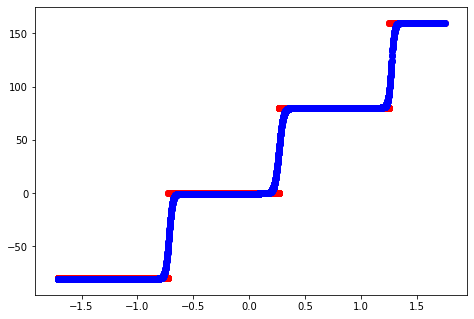

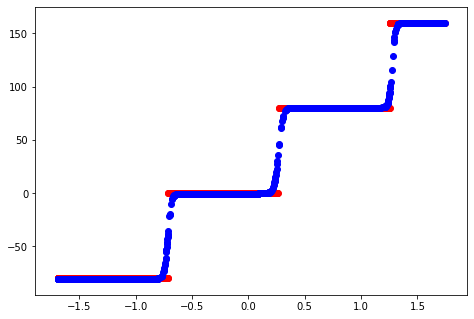

In [715]:
output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer, train_output_layer, color='r')
ax.scatter(train_input_layer,output_layer,color="b")
print("train MSE")
print(MSE(train_output_layer,output_layer)/output_layer.shape[0])

output_layer=mlp_test.calculate(test_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer, test_output_layer, color='r')
ax.scatter(test_input_layer,output_layer,color="b")
print("test MSE")
print(MSE(test_input_layer,output_layer)/output_layer.shape[0])

In [726]:
import seaborn as sns

In [717]:
#dla wielowarstwowych sieci gdy identity jest funkcja aktywacji to wagi eksploduja przy problemie regresji
df=df[df["accuracy_train"]<10**10]

In [718]:
df_c=df[df["problem"]=="classification"]

In [719]:
df_r=df[df["problem"]!="classification"]

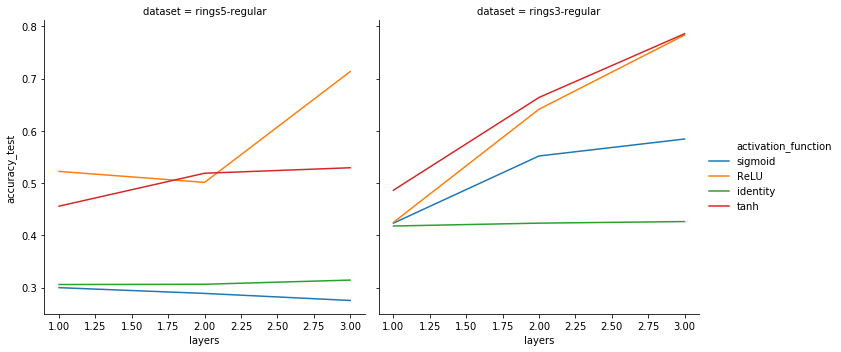

In [720]:
sns.relplot(x="layers",y="accuracy_test",hue="activation_function",col="dataset",kind="line",data=df_c)

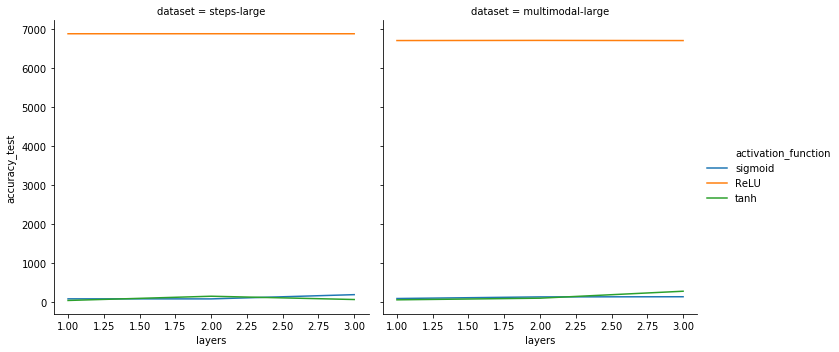

In [721]:
#dla problemu regresji im ni≈ºej tym lepiej "accuracy" to w tym wypadku MSE
sns.relplot(x="layers",y="accuracy_test",hue="activation_function",col="dataset",kind="line",data=df_r)

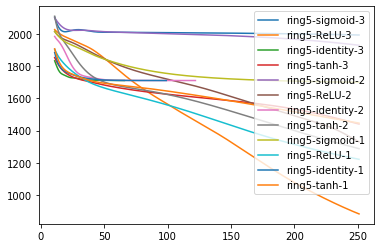

In [731]:
for x in range(0,12):
    t=np.arange(1,len(networks_err[x])+1,1)
    if networks_err[x][-1]<10**10:
        plt.plot(t[10:],networks_err[x][10:],label=networks_names[x])
    
plt.legend(loc="upper right")  

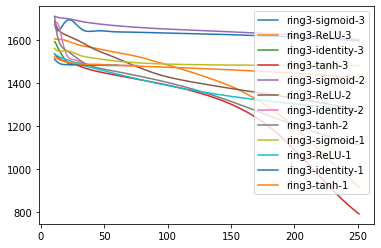

In [732]:
for x in range(12,24):
    t=np.arange(1,len(networks_err[x])+1,1)
    if networks_err[x][-1]<10**10:
        plt.plot(t[10:],networks_err[x][10:],label=networks_names[x])
    
plt.legend(loc="upper right") 

In [733]:
for x in range(24,36):
    t=np.arange(1,len(networks_err[x])+1,1)
    if networks_err[x][-1]<10**10:
        plt.plot(t[10:],networks_err[x][10:],label=networks_names[x])
    
plt.legend(loc="upper right") 

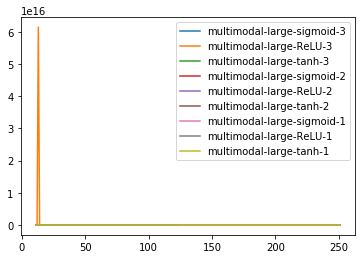

In [734]:
for x in range(36,48):
    t=np.arange(1,len(networks_err[x])+1,1)
    if networks_err[x][-1]<10**10:
        plt.plot(t[10:],networks_err[x][10:],label=networks_names[x])
    
plt.legend(loc="upper right") 

# Space for debugging

# OLD CLASS

In [141]:
def sigmoid_derivative(x):
    return(sigmoid(x)*(1-sigmoid(x)))

In [7]:
def sigmoid(x):
    return(1/(1 + np.exp(-x)))

In [11]:
class MLP:
    def __init__(self, input_layer_len, output_layer_len, hidden_layers_len, activation_function):
        
        self.activation_function = activation_function
        self.input_layer = np.zeros((1,input_layer_len))
        self.output_layer = np.zeros((1,output_layer_len))
        self.weights=[]
        
        self.weights.append(np.random.random((hidden_layers_len[0],input_layer_len))*2-1)
        
        for i in range(1,len(hidden_layers_len)):
            self.weights.append(np.random.random((hidden_layers_len[i],hidden_layers_len[i-1]))*2-1)
            
        self.weights.append(np.random.random((output_layer_len,hidden_layers_len[-1]))*2-1)
        
        self.biases=[]
        
        for i in range(len(hidden_layers_len)):
            self.biases.append(np.zeros((hidden_layers_len[i],1)))
            
        
        self.biases.append(np.zeros((output_layer_len,1)))
        
        self.hidden_layers=[]
        
        for i in range(len(hidden_layers_len)):
            self.hidden_layers.append(np.zeros((hidden_layers_len[i],1)))
        
    
        
    def calculate(self,input_layer,memory=False):
        self.input_layer=input_layer.copy()
        
        input_layer=input_layer.T
        
        if(memory):
            for i in range(len(self.weights)-1):
                
                self.hidden_layers[i]=self.weights[i].dot(input_layer)+self.biases[i]
                input_layer=self.activation_function(self.hidden_layers[i])
                
        else:    
            for i in range(len(self.weights)-1):
                input_layer=self.activation_function(self.weights[i].dot(input_layer)+self.biases[i])
                
        
        #mozliwe ze trzeba reshapy
        output_layer=(self.weights[-1].dot(input_layer)+self.biases[-1])
        #print(output_layer.shape)
        self.output_layer=output_layer.T.copy()
        
        
        return(output_layer.T)
        
    def train(self,train_input_layer,true_output_layer,rate=0.05,beta=0.8,batch=0.2,stop=10**-6,RMSprop=False,eps=10**-8):
        lin=np.linspace(0,train_input_layer.shape[0],int(train_input_layer.shape[0]*batch)).round().astype(int)
        output_layer=self.calculate(train_input_layer)
        error=sum((true_output_layer-output_layer)**2)
        print(error)
        iteration=0
        old_gradient=[[0]*(len(lin)-1) for x in range(len(self.weights))]
        old_gradient_bias=[[0]*(len(lin)-1) for x in range(len(self.weights))]
        error_list=[error]

        for xd in range(2*10**3):
            iteration+=1

            for b in range(len(lin)-1):

                input_layer=train_input_layer[lin[b]:lin[b+1]]
                output_layer=self.calculate(input_layer,memory=True)
                batch_size=output_layer.shape[0]
                errors=[[0]*len(self.weights) for x in range(batch_size)]

                for x in range(batch_size):
                    #derivative of x is 1
                    errors[x][-1]=((output_layer[x]-true_output_layer[lin[b]:lin[b+1]][x])).reshape(-1,1)

                    for i in range(len(self.weights)-2,-1,-1): 
                        errors[x][i]=self.weights[i+1].T.dot(errors[x][i+1])*sigmoid_derivative(self.hidden_layers[i][:,x:x+1])

                for l in range(1,len(self.weights)):

                    if(RMSprop):
                        new_gradient=sum([errors[x][l].dot(self.activation_function(self.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                        old_gradient[l][b]=beta*old_gradient[l][b]+(1-beta)*new_gradient**2
                        self.weights[l]=self.weights[l]-new_gradient*(rate/(np.sqrt(old_gradient[l][b])+eps))

                        new_gradient_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                        old_gradient_bias[l][b]=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias**2
                        self.biases[l]=self.biases[l]-new_gradient_bias*(rate/(np.sqrt(old_gradient_bias[l][b])+eps))
                    else:
                        new_gradient=sum([errors[x][l].dot(self.activation_function(self.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                        new_gradient=beta*old_gradient[l][b]+(1-beta)*new_gradient
                        old_gradient[l][b]=new_gradient
                        self.weights[l]=self.weights[l]-new_gradient*rate

                        new_gradient_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                        new_gradient_bias=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias
                        old_gradient_bias[l][b]=new_gradient_bias
                        self.biases[l]=self.biases[l]-new_gradient_bias*rate

                if(RMSprop):
                    new_gradient=sum([errors[x][0].dot((self.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
                    old_gradient[0][b]=beta*old_gradient[0][b]+(1-beta)*new_gradient**2
                    self.weights[0]=self.weights[0]-new_gradient*(rate/(np.sqrt(old_gradient[0][b])+eps))

                    new_gradient_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
                    old_gradient_bias[0][b]=beta*old_gradient_bias[0][b]+(1-beta)*new_gradient_bias**2
                    self.biases[0]=self.biases[0]-new_gradient_bias*(rate/(np.sqrt(old_gradient_bias[0][b])+eps))
                else:
                    new_gradient=sum([errors[x][0].dot((self.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
                    new_gradient=beta*old_gradient[0][b]+(1-beta)*new_gradient
                    old_gradient[0][b]=new_gradient
                    self.weights[0]=self.weights[0]-new_gradient*rate

                    new_gradient_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
                    new_gradient_bias=beta*old_gradient_bias[0][b]+(1-beta)*new_gradient_bias
                    old_gradient_bias[0][b]=new_gradient_bias
                    self.biases[0]=self.biases[0]-new_gradient_bias*rate


            output_layer=self.calculate(train_input_layer)
            new_error=sum((true_output_layer-output_layer)**2)
            error_list.append(new_error)

            if(iteration % 1000 == 0):
                print(iteration)

            if (abs(new_error-error)/error)<stop:
                #print((new_error-error)/error)
                #print(iteration)
                break

            error=new_error
        
        print(iteration)
        print(error)
        return error_list

In [835]:
mlp_test=MLP_test(1,1,[4,6],[sigmoid,sigmoid,identity],[sigmoid_grad,sigmoid_grad,identity_grad],MSE,MSE_grad)

In [836]:
test = np.loadtxt("mio1/regression/multimodal-large-training.csv", delimiter=',', skiprows=1, usecols=range(1,3))

X=test[:,0].reshape(-1,1)

Y=test[:,1].reshape(-1,1)

train_input_layer=(X-X.mean())/X.std()

true_output_layer=(Y-Y.mean())/Y.std()

ValueError: x and y must be the same size

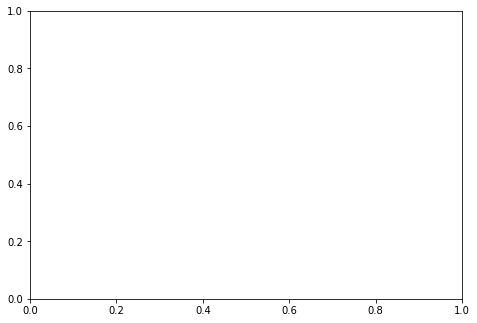

In [512]:
output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer, true_output_layer, color='r')
ax.scatter(train_input_layer,output_layer,color="b")

In [12]:
mlp=MLP(1,1,[15,17,19],sigmoid)

train_input_layer=(X-X.mean())/X.std()

true_output_layer=(Y-Y.mean())/Y.std()

rate=0.08

beta=0.8

batch=0.2

stop=10**-6

RMSprop=True

eps=10**-8

NameError: name 'X' is not defined

In [208]:
xd=np.ones((3,2))

In [212]:
softmax(xd)

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]])

In [214]:
sigmoid(xd)

array([[0.73105858, 0.73105858],
       [0.73105858, 0.73105858],
       [0.73105858, 0.73105858]])

In [ ]:
lin=np.linspace(0,train_input_layer.shape[0],int(train_input_layer.shape[0]*batch)).round().astype(int)
output_layer=mlp.calculate(train_input_layer)
error=sum((true_output_layer-output_layer)**2)
iteration=0
old_gradient=[[0]*(len(lin)-1) for x in range(len(mlp.weights))]
old_gradient_bias=[[0]*(len(lin)-1) for x in range(len(mlp.weights))]
error_list=[error]

for xd in range(1*10**1):
    iteration+=1
    
    for b in range(len(lin)-1):
        
        input_layer=train_input_layer[lin[b]:lin[b+1]]
        output_layer=mlp.calculate(input_layer,memory=True)
        batch_size=output_layer.shape[0]
        errors=[[0]*len(mlp.weights) for x in range(batch_size)]

        for x in range(batch_size):
            #derivative of x is 1
            errors[x][-1]=((output_layer[x]-true_output_layer[lin[b]:lin[b+1]][x])).reshape(-1,1)

            for i in range(len(mlp.weights)-2,-1,-1): 
                errors[x][i]=mlp.weights[i+1].T.dot(errors[x][i+1])*sigmoid_derivative(mlp.hidden_layers[i][:,x:x+1])

        for l in range(1,len(mlp.weights)):

            if(RMSprop):
                new_gradient=sum([errors[x][l].dot(mlp.activation_function(mlp.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                old_gradient[l][b]=beta*old_gradient[l][b]+(1-beta)*new_gradient**2
                mlp.weights[l]=mlp.weights[l]-new_gradient*(rate/(np.sqrt(old_gradient[l][b])+eps))
                
                new_gradient_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                old_gradient_bias[l][b]=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias**2
                mlp.biases[l]=mlp.biases[l]-new_gradient_bias*(rate/(np.sqrt(old_gradient_bias[l][b])+eps))
            else:
                new_gradient=sum([errors[x][l].dot(mlp.activation_function(mlp.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                new_gradient=beta*old_gradient[l][b]+(1-beta)*new_gradient
                old_gradient[l][b]=new_gradient
                mlp.weights[l]=mlp.weights[l]-new_gradient*rate

                new_gradient_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                new_gradient_bias=beta*old_gradient_bias[l][b]+(1-beta)*new_gradient_bias
                old_gradient_bias[l][b]=new_gradient_bias
                mlp.biases[l]=mlp.biases[l]-new_gradient_bias*rate

        if(RMSprop):
            new_gradient=sum([errors[x][0].dot((mlp.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
            old_gradient[0][b]=beta*old_gradient[0][b]+(1-beta)*new_gradient**2
            mlp.weights[0]=mlp.weights[0]-new_gradient*(rate/(np.sqrt(old_gradient[0][b])+eps))
            
            new_gradient_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
            old_gradient_bias[0][b]=beta*old_gradient_bias[0][b]+(1-beta)*new_gradient_bias**2
            mlp.biases[0]=mlp.biases[0]-new_gradient_bias*(rate/(np.sqrt(old_gradient_bias[0][b])+eps))
            print((np.sqrt(old_gradient_bias[0][b])+eps))
        else:
            new_gradient=sum([errors[x][0].dot((mlp.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
            new_gradient=beta*old_gradient[0][b]+(1-beta)*new_gradient
            old_gradient[0][b]=new_gradient
            mlp.weights[0]=mlp.weights[0]-new_gradient*rate

            new_gradient_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
            new_gradient_bias=beta*old_gradient_bias[0][b]+(1-beta)*new_gradient_bias
            old_gradient_bias[0][b]=new_gradient_bias
            mlp.biases[0]=mlp.biases[0]-new_gradient_bias*rate
        
        
    output_layer=mlp.calculate(train_input_layer)
    new_error=sum((true_output_layer-output_layer)**2)
    error_list.append(new_error)
    
    if(iteration % 1000 == 0):
        print(iteration)
    
    if (abs(new_error-error)/(error+eps))<stop:
        print((new_error-error)/error)
        print(iteration)
        break
    
    error=new_error

# OLD LAB

In [23]:
#square large
mlp_start=MLP(1,1,[10,8,12],sigmoid)

test = np.loadtxt("mio1/regression/square-large-training.csv", delimiter=',', skiprows=1,usecols=range(1,3))

X=test[:,0].reshape(-1,1)

Y=test[:,1].reshape(-1,1)

train_input_layer=(X-X.mean())/X.std()

true_output_layer=(Y-Y.mean())/Y.std()

In [78]:
#multimodal-large
mlp_start=MLP(1,1,[10,8,12],sigmoid)

test = np.loadtxt("mio1/regression/multimodal-large-training.csv", delimiter=',', skiprows=1, usecols=range(1,3))

X=test[:,0].reshape(-1,1)

Y=test[:,1].reshape(-1,1)

train_input_layer=(X-X.mean())/X.std()

true_output_layer=(Y-Y.mean())/Y.std()

In [24]:
#steps-large
mlp_start=MLP(1,1,[10,8,12],sigmoid)

test = np.loadtxt("mio1/regression/steps-large-training.csv", delimiter=',', skiprows=1, usecols=range(1,3))

X=test[:,0].reshape(-1,1)

Y=test[:,1].reshape(-1,1)

train_input_layer=(X-X.mean())/X.std()

true_output_layer=(Y-Y.mean())/Y.std()

In [25]:
mlp_vanilla=MLP(1,1,[10,8,12],sigmoid)
mlp_vanilla.weights=mlp_start.weights.copy()
mlp_vanilla.biases=mlp_start.biases.copy()

In [26]:
mlp_vanilla_batch=MLP(1,1,[10,8,12],sigmoid)
mlp_vanilla_batch.weights=mlp_start.weights.copy()
mlp_vanilla_batch.biases=mlp_start.biases.copy()

In [27]:
mlp_RMS=MLP(1,1,[10,8,12],sigmoid)
mlp_RMS.weights=mlp_start.weights.copy()
mlp_RMS.biases=mlp_start.biases.copy()

In [28]:
mlp_momentum=MLP(1,1,[10,8,12],sigmoid)
mlp_momentum.weights=mlp_start.weights.copy()
mlp_momentum.biases=mlp_start.biases.copy()

In [35]:
error_momentum=mlp_momentum.train(train_input_layer,true_output_layer,batch=0.1)

[347.79019007]
1000
2000
2000
[27.97169648]


In [18]:
error_vanilla_batch=mlp_vanilla_batch.train(train_input_layer,true_output_layer,beta=0)

[214.80715548]
1000
2000
2000
[0.03706813]


In [19]:
error_vanilla=mlp_vanilla.train(train_input_layer,true_output_layer,batch=1,beta=0)

[214.80715548]
1000
2000
2000
[0.0089865]


In [70]:
error_RMS=mlp_RMS.train(train_input_layer,true_output_layer,RMSprop=True,beta=0.999,batch=0.1,eps=10**-8,rate=0.001)

[575.67652086]


KeyboardInterrupt: 

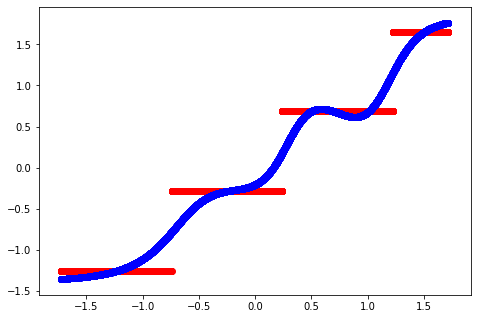

In [34]:
output_layer=mlp_momentum.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer, true_output_layer, color='r')
ax.scatter(train_input_layer,output_layer,color="b")

In [71]:
output_layer=mlp_RMS.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer, true_output_layer, color='r')
ax.scatter(train_input_layer,output_layer,color="b")

In [27]:
t = np.arange(1, 2002, 1)

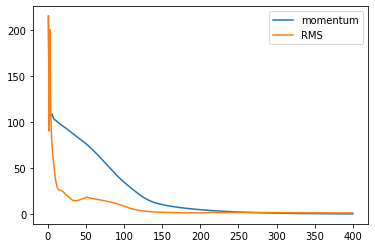

In [72]:
plt.plot(t[0:400],error_momentum[0:400],label="momentum")
plt.plot(t[0:400],error_RMS[0:400],label="RMS")
plt.legend(loc="upper right")

In [28]:
plt.plot(t[0:400],error_momentum[0:400],label="momentum")
plt.plot(t[0:400],error_vanilla[0:400],label="vanilla")
plt.plot(t[0:400],error_vanilla_batch[0:400],label="vanilla_batch")
plt.plot(t[0:400],error_RMS[0:400],label="RMS")
plt.legend(loc="upper right")

In [ ]:
error_momentum[-1]

In [ ]:
error_vanilla[-1]

In [ ]:
error_vanilla_batch[-1]

In [ ]:
error_RMS[-1]